<a href="https://colab.research.google.com/github/wolandmargarita/gpt2-finetune-novel-colors/blob/main/generate_new_colors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import nltk
import random
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.patches as patches
import transformers
import re
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel, AdamW, GPT2Config
from torch.utils.data import DataLoader, Dataset
from google.colab import userdata

In [ ]:
# Replace this environment variable with a dataset of your choosing to fine tune the checkpoint further
# This GPT2 model was initially trained using https://www.kaggle.com/datasets/avi1023/color-names

COLOR_NAMES_DS = userdata.get('COLOR_NAMES_DS')

# Get the color names dataset
df = pd.read_csv(COLOR_NAMES_DS)

# This is the name of the model at https://huggingface.co/womag/gpt2-finetune-novel-colors

model_name = 'womag/gpt2-finetune-novel-colors'

# Load the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Load the model
model = GPT2Model.from_pretrained(model_name)

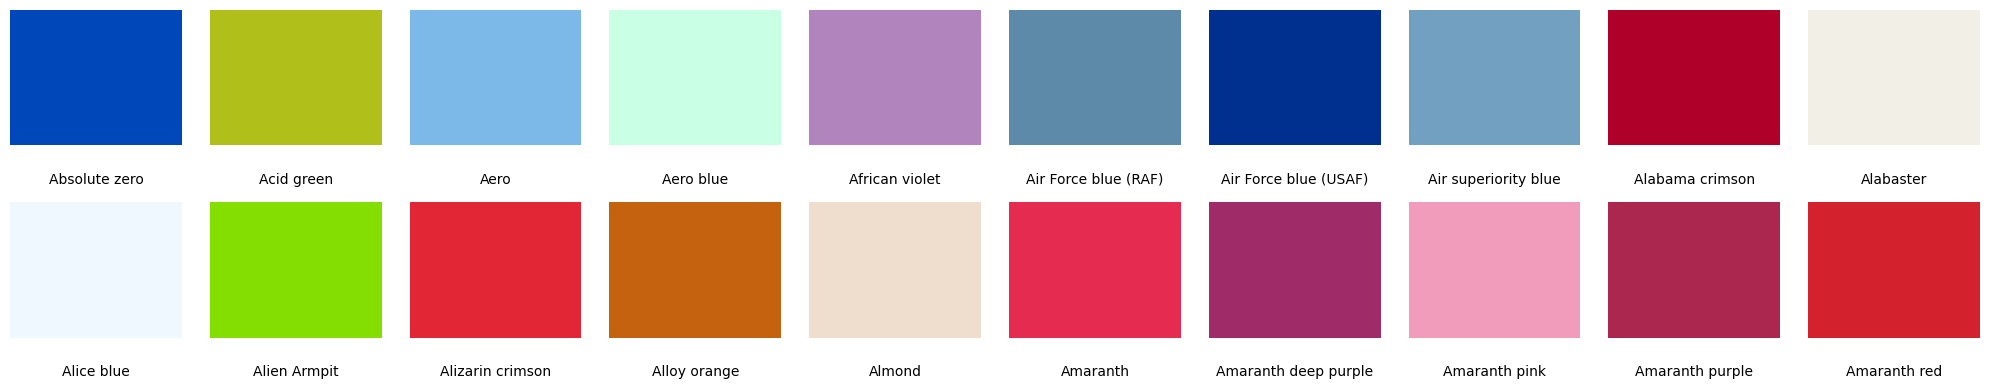

In [ ]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(2, 10, figsize=(20, 4))

# Flatten the array of axes to make it easier to iterate over
axs = axs.flatten()

# Iterate over the first 20 colors in your dataframe
for i in range(20):
    name = df.iat[i, 0]  # Color name
    hex = df.iat[i, 1]   # Hex code

    # Add a colored square, here we just use add_patch to add a rectangle
    axs[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=hex))

    # Add the color name as text underneath
    axs[i].text(0.5, -0.2, name, ha='center', va='top', fontsize=10, transform=axs[i].transAxes)

    # Remove the axes (so we only see the square)
    axs[i].set_axis_off()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
class GenerateColorsModel(torch.nn.Module):
    def __init__(self, model_path=None, model_name='gpt2', tokenizer_name='gpt2', dropout=0.1, attention_dropout=0.1):
        super(GenerateColorsModel, self).__init__()
        self.tokenizer = GPT2Tokenizer.from_pretrained(tokenizer_name)
        # Add any special tokens if needed

        # Correctly reference self.tokenizer to set the pad_token
        self.tokenizer.pad_token = self.tokenizer.eos_token

        if model_path:
            # It's critical to load the model and then adjust the token embedding sizes to match the tokenizer
            self.model = self.load_model_from_chkpt(model_path, model_name)

            # Ensure the model's token embeddings are correctly sized to match the tokenizer
            self.model.resize_token_embeddings(len(self.tokenizer))
        else:
            # Load a fresh model with the possibility to adjust its config
            self.config = GPT2Config.from_pretrained(model_name, dropout=dropout, attention_dropout=attention_dropout)
            self.model = GPT2LMHeadModel.from_pretrained(model_name, config=self.config)

        # Resize token embeddings - Necessary if you've added special tokens
        self.model.resize_token_embeddings(len(self.tokenizer))

    # Method to switch the underlying PyTorch model to evaluation mode
    def to_eval_mode(self):
        self.model.eval()

    def prepare_data_loader(self, formatted_data, batch_size=32):
        encodings = self.tokenizer(formatted_data, truncation=True, max_length=50, padding=True, return_tensors='pt')
        dataset = ColorDataSet(encodings)
        return DataLoader(dataset, batch_size=batch_size, shuffle=True)

    def load_model_from_chkpt(self, model_save_path, model_name):
        # Load model architecture first

        model = GPT2LMHeadModel.from_pretrained(model_name)

        # Load the checkpoint
        checkpoint = torch.load(model_save_path, map_location=torch.device('cpu'))

        # Apply the state dictionary to the model
        model.load_state_dict(checkpoint, strict=False)  # Use strict=False to ignore non-matching keys

        return model

    def generate_color_names(self, prompt_text, max_length=100, temperature=1.2, top_k=100, num_return_sequences=20):

        # Set the model to evaluation mode
        self.model.eval()

        # Encode the prompt text to tensor
        encoded_prompt = self.tokenizer.encode(prompt_text, add_special_tokens=False, return_tensors="pt")

        # Generate a sequence of tokens after the prompt
        output_seq = self.model.generate(
            input_ids=encoded_prompt,
            max_length=max_length,
            temperature=temperature,
            top_k=top_k,
            do_sample=True,  # Enable sampling MUST BE True
            num_return_sequences=num_return_sequences,
            pad_token_id=self.tokenizer.eos_token_id,  # Explicitly set pad_token_id
            no_repeat_ngram_size=2
        )

        # Decode the tokens back into text
        generated_text = []

        for generated_sequence in output_seq:
            text = self.tokenizer.decode(generated_sequence, skip_special_tokens=True)
            generated_text.append(text[len(prompt_text):].strip())

        return generated_text


    def train(self, formatted_data, model_save_path, num_epochs=2, learning_rate=0.0005, weight_decay=0.01):

        data_loader = self.prepare_data_loader(formatted_data, batch_size=32)
        optimizer = optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        self.model.train()
        for epoch in range(num_epochs):
            for batch_num, batch in enumerate(data_loader, start=1):
                inputs, labels = batch['input_ids'], batch['input_ids']
                optimizer.zero_grad()
                outputs = self.model(inputs, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

                print(f'Epoch: {epoch}, Batch: {batch_num}, Loss: {loss.item()}')

        # Save the model
        torch.save(self.model.state_dict(), model_save_path)
        print(f"Model successfully saved at {model_save_path}")


    def correct_hex_value(self, hex_value):
        # This regex matches well-formed hex values
        hex_regex = re.compile(r'^#([0-9A-Fa-f]{6})$')

        # Check if the hex value is well-formed
        if hex_regex.match(hex_value):
            return hex_value  # Return as is if well-formed

        # Strip leading '#' if present
        hex_value = hex_value.lstrip('#')

        # Truncate if longer than 6 characters or pad with '0' if shorter
        if len(hex_value) > 6:
            corrected_hex = hex_value[:6]
        else:
            corrected_hex = hex_value.ljust(6, '0')

        # Return the corrected hex value with '#' prefix
        return '#' + corrected_hex

    def format_colors_for_display(self, generated_color_names):
        color_list = []
        for color in generated_color_names:
          components = color.split(',')
          color_list.append(components)

        color_dict = {}
        for color in color_list:
            color_name = color[0].strip()
            hex_value = color[1].split(':')[1].strip()
            hex_value = self.correct_hex_value(hex_value)
            color_dict[color_name] = hex_value

        return color_dict

    def display_colors(self, generated_color_names):

        color_dict = self.format_colors_for_display(generated_color_names)
        # Create a figure and a grid of subplots
        fig, axs = plt.subplots(2, 10, figsize=(20, 4))

        # Flatten the array of axes to make it easier to iterate over
        axs = axs.flatten()

        # Iterate over the first 20 colors in your dataframe
        for i, (name, color) in enumerate(color_dict.items()):

            if i > 20:
              break

            # Add a colored square, here we just use add_patch to add a rectangle
            axs[i].add_patch(patches.Rectangle((0, 0), 1, 1, color=color))

            # Add the color name as text underneath
            axs[i].text(0.5, -0.2, name, ha='center', va='top', fontsize=10, transform=axs[i].transAxes)

            # Remove the axes (so we only see the square)
            axs[i].set_axis_off()

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

class ColorDataSet(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings.input_ids)

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [ ]:
# Stringify the new data to pass to the tokenizer
dataframe_as_string = df.apply(lambda x: f"Color: {x['Name']}, Hex: {x['Hex (24 bit)']}, Red: {x['Red (8 bit)']}, Green: {x['Green (8 bit)']}, Blue: {x['Blue (8 bit)']}, Hue: {x['Hue (degrees)']}, HSL.S: {x['HSL.S (%)']}, Shade: {x['HSL.L (%), HSV.S (%), HSV.V (%)']}", axis=1).tolist()


In [ ]:
#TRAINING

# Assumes to start training from a checkpoint
model = GenerateColorsModel()

model.train(dataframe_as_string, model_path)

In [ ]:
model = GenerateColorsModel(model_path=model_path)

In [ ]:
# Prompt the model to generate new colors

prompt_text = "Name:"  # Adjust the prompt as needed

# Run inference on the model
generated_color_names = model.generate_color_names(prompt_text)

model.display_colors(generated_color_names)


NameError: name 'model' is not defined